In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [ ]:
%matplotlib notebook

In [ ]:
os.chdir('..')

In [ ]:
os.getcwd()

In [ ]:
col_arr = [0]*54
for i in range(0,54):
    col_arr[i] = i

path1 ='data/Day1/Post/DataFeatures1.csv'
path2 ='data/Day2/Post1/DataFeatures2.csv' 
path3 ='data/Day2/Post2/DataFeatures.csv' 
path4 ='data/Day3/Post/DataFeatures4.csv'
path5 ='data/Day4/Post/DataFeatures.csv'

df1=(pd.read_csv(path1 ,header = None, usecols = col_arr))
df2=(pd.read_csv(path2 ,header = None, usecols = col_arr))
df3=(pd.read_csv(path3 ,header = None, usecols = col_arr))
df4=(pd.read_csv(path4 ,header = None, usecols = col_arr))
df5=(pd.read_csv(path5 ,header = None, usecols = col_arr))

In [6]:
df1 = np.array(df1)
df2 = np.array(df2)
df3 = np.array(df3)
df4 = np.array(df4)
df5 = np.array(df5)

In [7]:
df = np.concatenate((df1, df2, df3, df4, df5))
df = pd.DataFrame(df)
df = df.fillna(0)

In [8]:
f = [i for i in range(1, 53)]
Y = df[53]
X = df[f]
X = np.array(X)
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

X = X[:-520]
Y = Y[:-520]

In [9]:
print(X.shape)
print(Y.shape)

(115098, 52)
(115098, 1)


In [10]:
cv_split = 0.4
len_train = int( X.shape[0] * (1 - cv_split) )
len_CV = int( X.shape[0] * cv_split )

X_train = X[0 : len_train]
Y_train = Y[0 : len_train]
X_CV = X[len_train : ]
Y_CV = Y[len_train : ]

print(X_train.shape)
print(Y_train.shape)
print(X_CV.shape)
print(Y_CV.shape)

(69058, 52)
(69058, 1)
(46040, 52)
(46040, 1)


In [ ]:
#plt.plot(Y_train[0:3000])
#plt.xlabel('Timestamp')
#plt.ylabel('Breaths/min')
#plt.title('Respiratory Rate (Zoomed)')
#plt.savefig('assets/RR_zoomed.png')

<IPython.core.display.Javascript object>


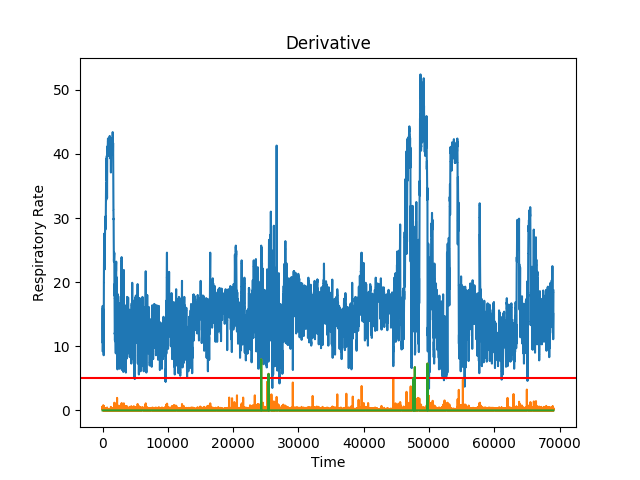

Text(0.5,1,'Respiratory Rate (Total)')

In [11]:
plt.plot(Y_train)
plt.xlabel('Timestamp')
plt.ylabel('Breaths/min')
plt.title('Respiratory Rate (Total)')
#plt.savefig('assets/RR_total.png')

In [15]:
grad = np.gradient(Y_train[:,0])
abs_grad = np.absolute(grad)

<IPython.core.display.Javascript object>


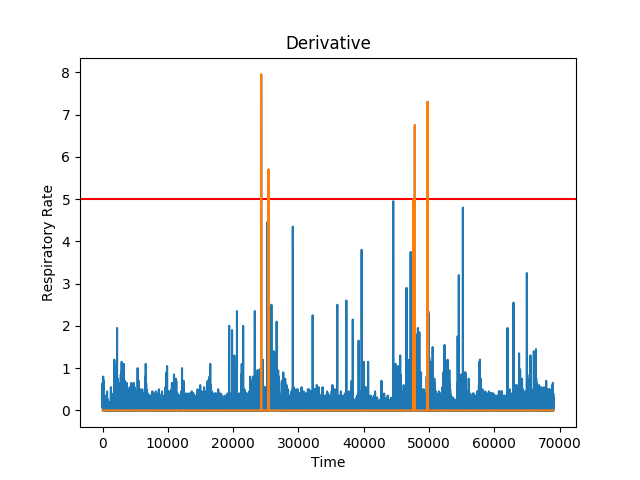

In [16]:
plt.plot(abs_grad)
plt.title('Derivative')
plt.xlabel('Time')
plt.ylabel('Respiratory Rate')
plt.savefig('assets/grad.png')

In [17]:
thresh = 5 
for i in range(abs_grad.shape[0]):
    if(abs_grad[i] < thresh):
        abs_grad[i] = 0

plt.axhline(y=thresh, color='r', linestyle='-')
plt.plot(abs_grad)
plt.title('Derivative')
plt.xlabel('Time')
plt.ylabel('Respiratory Rate')
#plt.savefig('assets/grad_thresh.png')

Text(55.8472,0.5,'Respiratory Rate')

In [18]:
np.nonzero(abs_grad)

(array([24292, 24293, 25423, 25424, 47617, 47829, 47830, 49762, 49763]),)

<IPython.core.display.Javascript object>


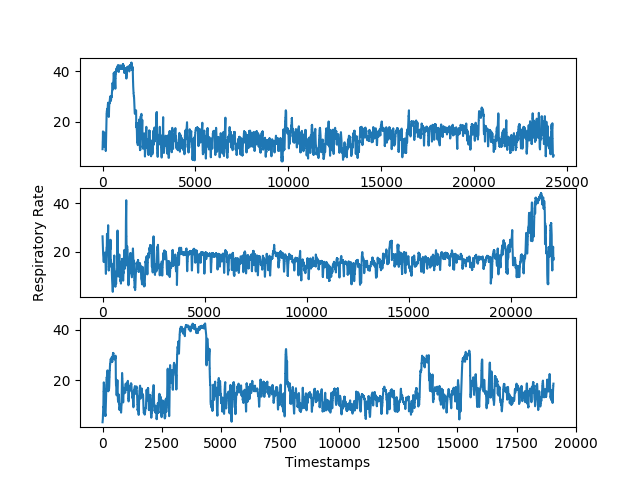

16.25506358134132


In [19]:
X_train1 = X_train[  0   : 24270]
Y_train1 = Y_train[  0   : 24270]

X_train2 = X_train[25500 : 47600]
Y_train2 = Y_train[25500 : 47600]

X_train3 = X_train[50000 : 91300]
Y_train3 = Y_train[50000 : 91300]

plt.subplot(3,1,1)
plt.plot(Y_train1)

plt.subplot(3,1,2)
plt.plot(Y_train2)
plt.ylabel('Respiratory Rate')

plt.subplot(3,1,3)
plt.plot(Y_train3)
plt.xlabel('Timestamps')

meanRate = (np.sum(Y_train1) + np.sum(Y_train2) + np.sum(Y_train3))/(Y_train1.shape[0]+Y_train2.shape[0]+Y_train3.shape[0])
print(meanRate)

plt.savefig('assets/sets.png')

[9.83923367e-01 7.49713595e-03 3.81356880e-03 2.76493127e-03
 1.75224315e-03 2.31987350e-04 1.14063100e-05 3.29574797e-06
 2.05718963e-06 5.15180932e-09 1.63478927e-09 1.98981121e-10
 4.79699731e-13 3.36553299e-13 2.86599065e-13 2.46757446e-13
 1.68966117e-13 1.65731443e-13 1.43007907e-13 1.27240806e-13
 9.65842334e-14 8.72966803e-14 7.98446462e-14 7.89778437e-14
 6.39815028e-14 6.01076450e-14 5.27390121e-14 3.71128949e-14
 1.34502912e-14 1.10087628e-14 7.38955204e-15 6.59041942e-15
 5.74478200e-15 3.60643575e-15 2.97043180e-15 2.40827443e-15
 2.16971787e-15 1.86756286e-15 1.53149904e-15 1.22716102e-15
 9.84312811e-16 5.22026766e-16 2.52176349e-16 1.69985428e-16
 5.87951862e-17 6.10630937e-18 5.10128044e-18 4.39443432e-18
 1.97606993e-18 1.64953430e-18 1.46199968e-18 1.13981134e-18]


<StemContainer object of 3 artists>

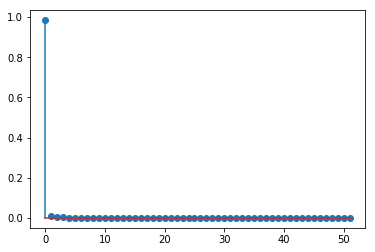

In [20]:
%matplotlib inline
pca_check = PCA()
pca_check.fit(X_train1)
pca_check.fit(X_train2)
pca_check.fit(X_train3)

print(pca_check.explained_variance_ratio_)
plt.stem(pca_check.explained_variance_ratio_)
#print("\n")
#print(pca_check.explained_variance_ratio_.cumsum())

In [21]:
n_components = 9
pca = PCA(n_components=n_components)

pca.fit(X_train1)
pca.fit(X_train2)
pca.fit(X_train3)

X1_pca = pca.transform(X_train1)
X2_pca = pca.transform(X_train2)
X3_pca = pca.transform(X_train3)

print(X1_pca.shape)
print(X2_pca.shape)
print(X3_pca.shape)

(24270, 9)
(22100, 9)
(19058, 9)


In [22]:
# Standardizing all the features with Zero Mean and Unit Variance
scalerX = StandardScaler()
scalerY = StandardScaler()

scalerX.fit(X1_pca)
scalerX.fit(X2_pca)
scalerX.fit(X3_pca)

scalerY.fit(Y_train1)
scalerY.fit(Y_train2)
scalerY.fit(Y_train3)


X_train1 = scalerX.transform(X1_pca)
X_train2 = scalerX.transform(X2_pca)
X_train3 = scalerX.transform(X3_pca)

Y_train1 = scalerY.transform(Y_train1)
Y_train2 = scalerY.transform(Y_train2)
Y_train3 = scalerY.transform(Y_train3)

In [23]:
# Apply same transformations in the Test/Cross-Validation data
X_CV = pca.transform(X_CV)
X_CV = scalerX.transform(X_CV)

Y_CV = scalerY.transform(Y_CV)

In [24]:
def getSeqData(X, Y, seqlength):
    x, y = [], []
    for i in range(X.shape[0]-seqlength):
        x.append(X[i : i+seqlength])
        y.append(Y[i+seqlength])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [25]:
sequence_length = 32
XT1, YT1 = getSeqData(X_train1, Y_train1, sequence_length)
XT1, _, YT1, _ = train_test_split(XT1, YT1, test_size=0, random_state=2)
print(XT1.shape)
print(YT1.shape)

XT2, YT2 = getSeqData(X_train2, Y_train2, sequence_length)
XT2, _, YT2, _ = train_test_split(XT2, YT2, test_size=0, random_state=2)
print(XT2.shape)
print(YT2.shape)

XT3, YT3 = getSeqData(X_train3, Y_train3, sequence_length)
XT3, _, YT3, _ = train_test_split(XT3, YT3, test_size=0, random_state=2)
print(XT3.shape)
print(YT3.shape)

X_CV, Y_CV = getSeqData(X_CV, Y_CV, sequence_length)
print(X_CV.shape)
print(Y_CV.shape)

len_train1 = X_train1.shape[0]
len_train2 = X_train2.shape[0]
len_train3 = X_train3.shape[0]
len_CV = X_CV.shape[0]


(24238, 32, 9)
(24238, 1)
(22068, 32, 9)
(22068, 1)
(19026, 32, 9)
(19026, 1)
(46008, 32, 9)
(46008, 1)


**Model Architecture**

In [26]:
'''
Reference : 
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dynamic_rnn.ipynb
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/linear_regression.py
'''

'\nReference : \nhttps://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dynamic_rnn.ipynb\nhttps://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/linear_regression.py\n'

In [27]:
learning_rate = 1e-4
epochs = 10
batch_size = 128
input_dimension = n_components
num_hidden1 = 128
num_hidden2 = 128

drop_prob = 0.3

train_loss_arr = []
cv_loss_arr = []

In [28]:
total_batches1 = int(len_train1/batch_size)
total_batches2 = int(len_train2/batch_size)
total_batches3 = int(len_train3/batch_size)
total_batches_CV = int(len_CV/batch_size)

In [29]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, sequence_length, input_dimension])
y = tf.placeholder(tf.float32, [None, 1])

# Define weights
weights = {'lstm2fc1': tf.Variable(tf.random_normal([num_hidden2, 64])), 
           'fc1_fc2': tf.Variable(tf.random_normal([64, 1]))}

biases = {'lstm2fc1': tf.Variable(tf.random_normal([64])), 
          'fc1_fc2': tf.Variable(tf.random_normal([1]))}

In [30]:
def RNNCell(x, sequence_length, num_hidden):
    x_unstacked = tf.unstack(x, sequence_length, 1)
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden)
    outputs, states = tf.nn.static_rnn(lstm_cell, x_unstacked, dtype=tf.float32)
    return outputs

# Reference : https://www.oreilly.com/ideas/introduction-to-lstms-with-tensorflow
def MultiRNNCell(x, sequence_length, batch_size, num_hidden1, num_hidden2):
    
    x_unstacked = tf.unstack(x, sequence_length, 1)
    
    lstm_cell1 = tf.nn.rnn_cell.BasicLSTMCell(num_hidden1, state_is_tuple=True)
    lstm_cell2 = tf.nn.rnn_cell.BasicLSTMCell(num_hidden2, state_is_tuple=True)
    
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell1, lstm_cell2], state_is_tuple=True)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    lstm_outputs, final_state = tf.nn.static_rnn(cell, x_unstacked, initial_state=init_state)
    
    return lstm_outputs
    

    


In [31]:
outputs = MultiRNNCell(x, sequence_length, batch_size, num_hidden1, num_hidden2)

drop1 = tf.layers.dropout(outputs[-1], rate=drop_prob)
layer1 = tf.matmul(drop1, weights['lstm2fc1']) + biases['lstm2fc1']
act1 = tf.nn.relu(layer1)

pred = tf.matmul(act1, weights['fc1_fc2']) + biases['fc1_fc2']

In [32]:
cost =  tf.losses.mean_squared_error(pred, y)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
with tf.Session() as sess:
    
    if(os.path.isfile('model/model.meta')):
        saver_restore = tf.train.import_meta_graph('model/model.meta')
        saver_restore.restore(sess, 'model/model')
        print('Restored Model Successfully')
        
    sess.run(init)
    
    for epoch in range(epochs):
        
        train_loss = 0
        for batch in range(total_batches1):
            batch_x = XT1[batch*batch_size : (batch+1)*batch_size]
            batch_y = YT1[batch*batch_size : (batch+1)*batch_size]
            sess.run(optimizer, feed_dict={x : batch_x, y : batch_y})
            train_loss += sess.run(cost, feed_dict={x : batch_x, y : batch_y})
        
        for batch in range(total_batches2):
            batch_x = XT2[batch*batch_size : (batch+1)*batch_size]
            batch_y = YT2[batch*batch_size : (batch+1)*batch_size]
            sess.run(optimizer, feed_dict={x : batch_x, y : batch_y})
            train_loss += sess.run(cost, feed_dict={x : batch_x, y : batch_y})
        
        for batch in range(total_batches3):
            batch_x = XT3[batch*batch_size : (batch+1)*batch_size]
            batch_y = YT3[batch*batch_size : (batch+1)*batch_size]
            sess.run(optimizer, feed_dict={x : batch_x, y : batch_y})
            train_loss += sess.run(cost, feed_dict={x : batch_x, y : batch_y})
        
        train_loss_arr.append(train_loss)
        
        
        
        cv_loss = 0
        for batch in range(total_batches_CV):
            batch_x = X_CV[batch*batch_size : (batch+1)*batch_size]
            batch_y = Y_CV[batch*batch_size : (batch+1)*batch_size]
            cv_loss += sess.run(cost, feed_dict={x : batch_x, y : batch_y})
        
        cv_loss_arr.append(cv_loss)
        
        save_path = saver.save(sess, "model/model")
        
        print('Epoch :', epoch+1, '   Train Loss :', train_loss, '   CV Loss :', cv_loss )

Epoch : 1    Train Loss : 221.72177949547768    CV Loss : 159.69502747431397
Epoch : 2    Train Loss : 148.2432607859373    CV Loss : 145.49966552481055
Epoch : 3    Train Loss : 129.43214744329453    CV Loss : 139.66713169962168
Epoch : 4    Train Loss : 119.5155718550086    CV Loss : 136.3360673300922
Epoch : 5    Train Loss : 113.03981327265501    CV Loss : 133.63712325319648
Epoch : 6    Train Loss : 108.4929445758462    CV Loss : 131.375720648095
Epoch : 7    Train Loss : 105.0338564440608    CV Loss : 129.61885260045528
Epoch : 8    Train Loss : 102.35687241703272    CV Loss : 127.96244251541793
Epoch : 9    Train Loss : 100.15021999180317    CV Loss : 126.5922883450985
Epoch : 10    Train Loss : 98.36931405961514    CV Loss : 125.53272903524339


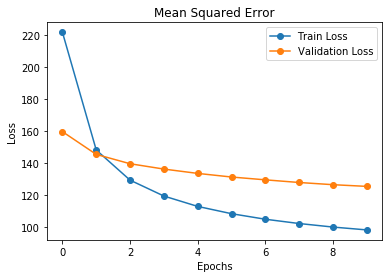

In [46]:
%matplotlib inline

tr, = plt.plot(train_loss_arr, label='Train Loss', marker='o')
cv, = plt.plot(cv_loss_arr, label='Validation Loss', marker='o')
plt.legend([tr, cv], ['Train Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mean Squared Error')
plt.savefig('assets/loss.png')

In [36]:
Y_pred = []

with tf.Session() as sess:
    saver_restore = tf.train.import_meta_graph('model/model.meta')
    saver_restore.restore(sess, 'model/model')
    
    for batch in range(total_batches_CV):
            batch_x = X_CV[batch*batch_size : (batch+1)*batch_size]
            batch_y = Y_CV[batch*batch_size : (batch+1)*batch_size]
            out = sess.run(pred, feed_dict={x : batch_x, y : batch_y})
            Y_pred.append(out)

INFO:tensorflow:Restoring parameters from model/model


In [37]:
r = np.array(Y_pred)
prediction = r.ravel()

pred_len = prediction.shape[0]
original_len = Y_CV.shape[0]

In [38]:
original = scalerY.inverse_transform(Y_CV)
prediction = scalerY.inverse_transform(prediction)

pad = [meanRate] * (original_len - pred_len)
pad = np.array(pad)
prediction = np.append(pad, prediction)

error = np.sqrt(mean_squared_error(original, prediction))
print('RMSE =', error)

RMSE = 4.83553290346402


<IPython.core.display.Javascript object>


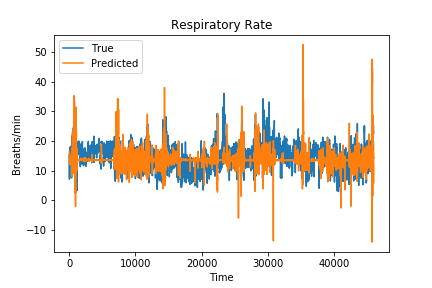

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [48]:
%matplotlib notebook

true_reading, = plt.plot(original, label='True')
predicted_reading, = plt.plot(prediction, label='Predicted')
plt.legend([true_reading, predicted_reading], ['True', 'Predicted'])
plt.xlabel('Time')
plt.ylabel('Breaths/min')
plt.title('Respiratory Rate')
plt.savefig('assets/Prediction.png')

In [42]:
train_loss_arr = [221.72177949547768, 
                  148.2432607859373,
                  129.43214744329453,
                  119.5155718550086,
                  113.03981327265501,
                  108.4929445758462,
                  105.0338564440608,
                  102.35687241703272,
                  100.15021999180317,
                  98.36931405961514]                        

In [44]:
cv_loss_arr = [159.69502747431397,
 145.49966552481055,
 139.66713169962168,
 136.3360673300922,
 133.63712325319648,
 131.375720648095,
 129.61885260045528,
 127.96244251541793,
 126.5922883450985,
 125.53272903524339]